In [4]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,matplotlib,sklearn,pandas,torch

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy     : 1.26.4
scipy     : 1.13.1
matplotlib: 3.8.0
sklearn   : 1.5.2
pandas    : 2.2.2
torch     : 2.5.0+cu121

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## VGG-16 on CIFAR-10

### Imports

In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [7]:
RANDOM_SEED = 42
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=1)

In [8]:
set_all_seeds(RANDOM_SEED)

In [9]:
## CIFAR 10

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77% vs. ~80% for 64x64 , upscaled to 70x70 gives ~85% acc.

# Random crop - reduces overfitting - less sensitive to exact position of object in image

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)),
    torchvision.transforms.RandomCrop((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)),
    torchvision.transforms.CenterCrop((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# Assuming get_dataloaders_cifar10 is your function to get the dataloaders
def get_dataloaders_cifar10(batch_size, validation_fraction, train_transforms, test_transforms, num_workers, subset_fraction=None):
    # Load the entire CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

    # If you want a subset of data, randomly sample indices
    if subset_fraction:
        # Compute the number of samples to select for the subset
        subset_size = int(len(train_dataset) * subset_fraction)
        subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)

        # Create a subset of the training dataset
        train_dataset = Subset(train_dataset, subset_indices)

    # Create validation dataset by splitting the training dataset
    val_size = int(len(train_dataset) * validation_fraction)
    train_size = len(train_dataset) - val_size

    # Split into training and validation datasets
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create DataLoaders for training, validation, and test datasets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, valid_loader, test_loader

# Example usage: Loading a subset of the CIFAR-10 dataset
BATCH_SIZE = 64
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=transforms.ToTensor(),
    test_transforms=transforms.ToTensor(),
    num_workers=2,
    subset_fraction=0.2  # Load only 20% of the training data
)


100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# Print the size of the training, validation, and test datasets
print(f"Size of training dataset: {len(train_loader.dataset)}")
print(f"Size of validation dataset: {len(valid_loader.dataset)}")
print(f"Size of test dataset: {len(test_loader.dataset)}")

Size of training dataset: 9000
Size of validation dataset: 1000
Size of test dataset: 10000


In [14]:
import torch

# Check if CUDA is available
print(torch.cuda.is_available())

# List available GPUs
print(torch.cuda.device_count())

# Get the name of the device
print(torch.cuda.get_device_name(0))  # Check GPU name for device 0


True
1
Tesla T4


In [15]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available devices: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")
torch.cuda.empty_cache()


Available devices: 1
Device name: Tesla T4


### Model

In [16]:
##########################
### MODEL
##########################

class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_3 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )


        self.block_4 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        height, width = 3, 3 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )

        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()

        '''
        Kaiming Uniform initialization is used for the weights of the Conv2d and Linear layers.
        The biases are initialized to zero.
        W ~ U(-bound, bound), where bound = sqrt(6 / (fan_in))
        '''

        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))


    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten

        logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)

        return logits

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 001/050 | Batch 0000/0141 | Loss: 2.8017
Epoch: 001/050 | Batch 0100/0141 | Loss: 2.2867
Epoch: 001/050 | Train: 12.27% | Validation: 14.00%
Time elapsed: 0.17 min
Epoch: 002/050 | Batch 0000/0141 | Loss: 2.2824
Epoch: 002/050 | Batch 0100/0141 | Loss: 2.1565
Epoch: 002/050 | Train: 23.22% | Validation: 23.40%
Time elapsed: 0.29 min
Epoch: 003/050 | Batch 0000/0141 | Loss: 1.9212
Epoch: 003/050 | Batch 0100/0141 | Loss: 1.8417
Epoch: 003/050 | Train: 33.86% | Validation: 30.80%
Time elapsed: 0.42 min
Epoch: 004/050 | Batch 0000/0141 | Loss: 1.6515
Epoch: 004/050 | Batch 0100/0141 | Loss: 1.5677
Epoch: 004/050 | Train: 36.73% | Validation: 36.10%
Time elapsed: 0.55 min
Epoch: 005/050 | Batch 0000/0141 | Loss: 1.6264
Epoch: 005/050 | Batch 0100/0141 | Loss: 1.6118
Epoch: 005/050 | Train: 42.49% | Validation: 40.50%
Time elapsed: 0.68 min
Epoch: 006/050 | Batch 0000/0141 | Loss: 1.5574
Epoch: 006/050 | Batch 0100/0141 | Loss: 1.6400
Epoch: 006/050 | Train: 49.76% | Validation: 43.9

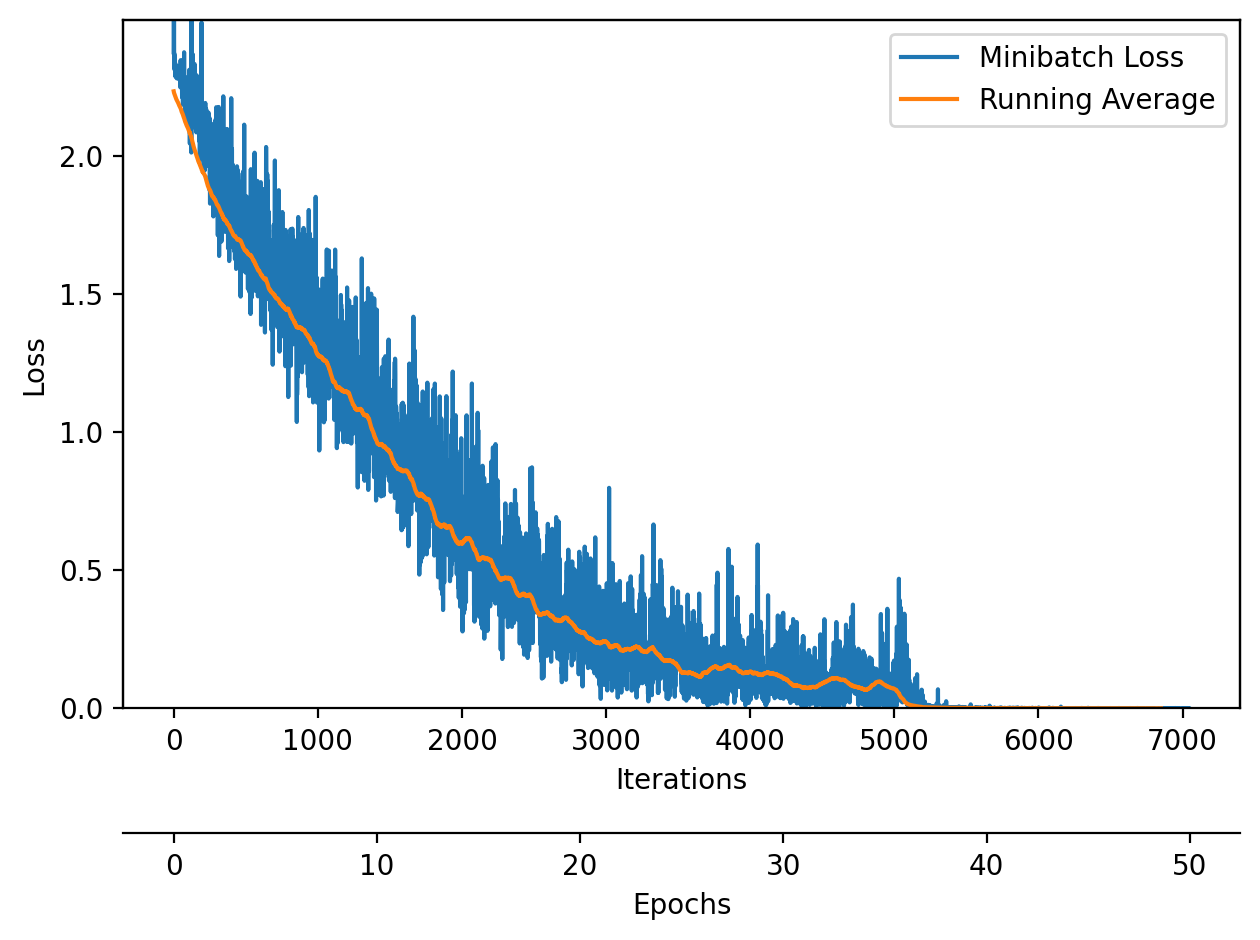

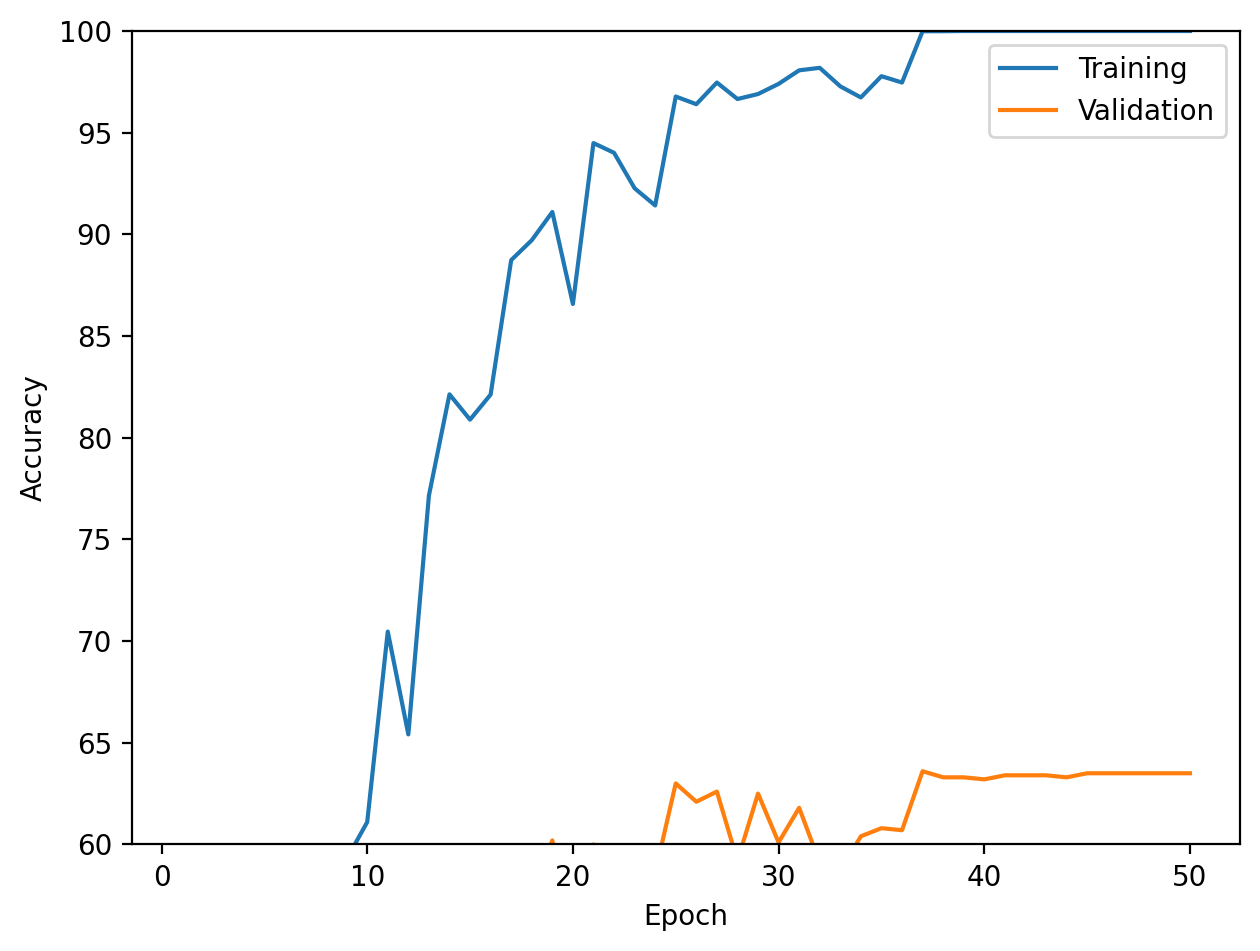

2024-11-09 17:28:07.968096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 17:28:07.987694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 17:28:07.993421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 17:28:08.007414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 17:28:09.024006: W tensorflow/comp

In [17]:
model = VGG16(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

!tensorboard --logdir=runs

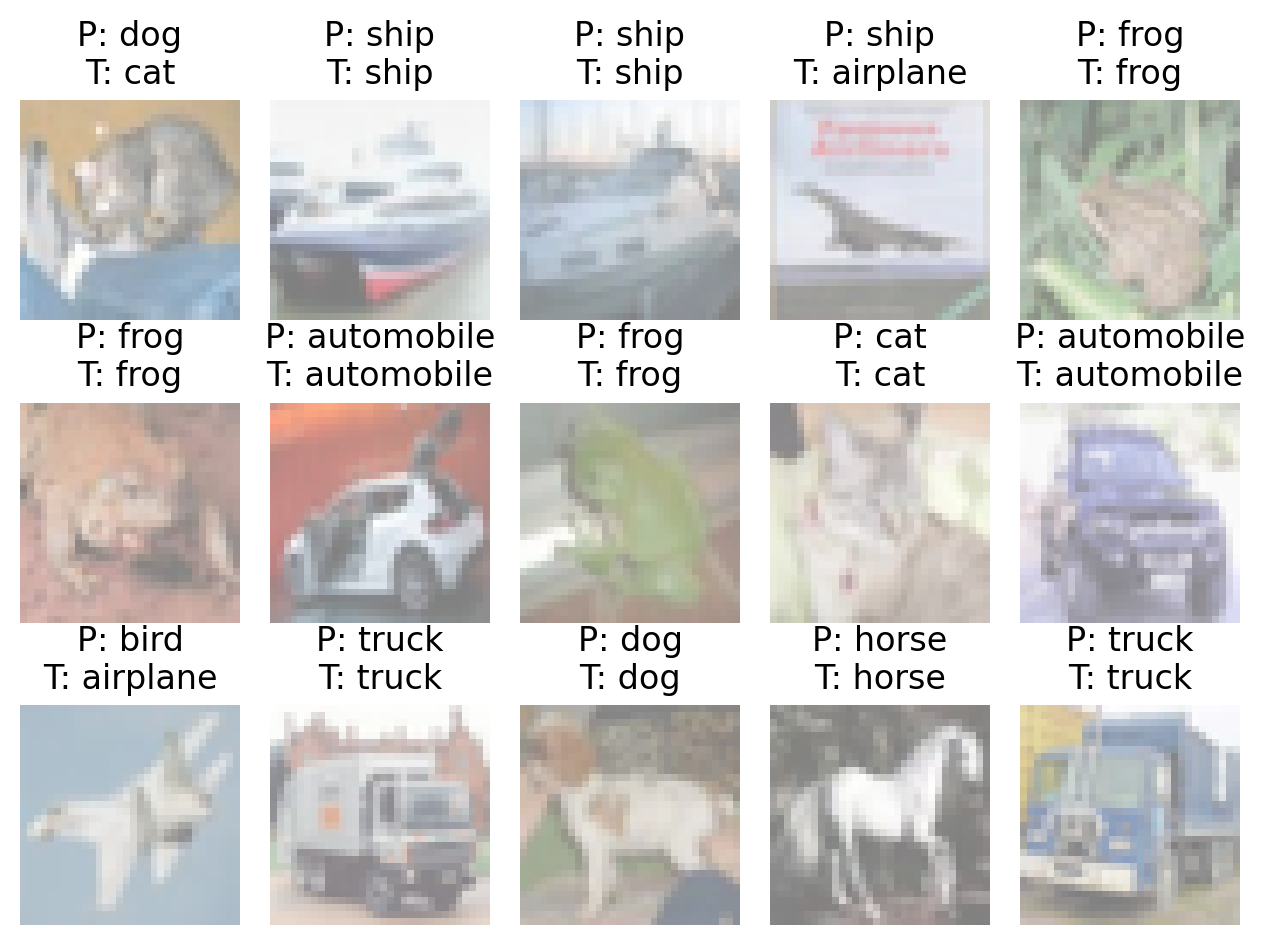

In [18]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

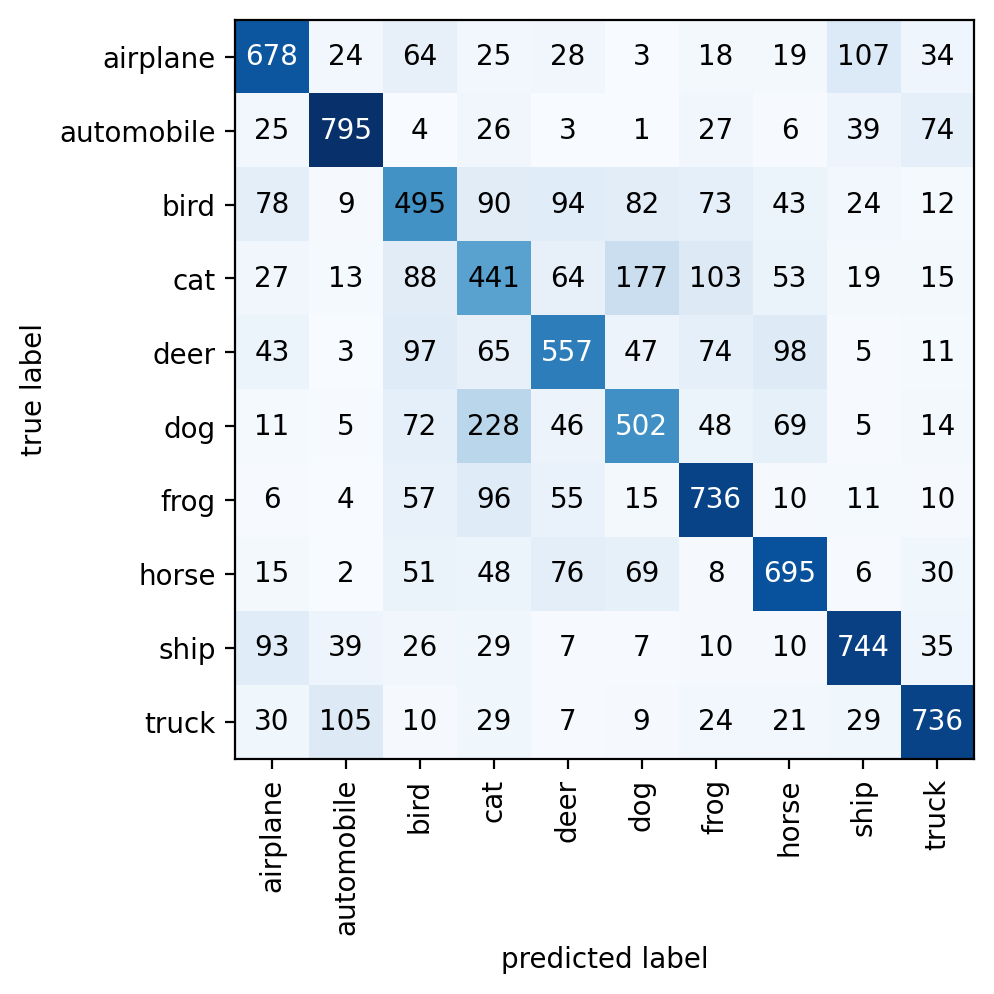

In [19]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()